<a href="https://colab.research.google.com/github/Gratisfo/project_ml/blob/main/%D0%90%D1%83%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B4%D0%B8%D1%81%D1%82%D1%80%D0%B8%D0%B1%D1%83%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Блок 1: Аугментация с заменой слов на основе word2vec **



In [ ]:
!wget -c http://vectors.nlpl.eu/repository/20/180.zip
!unzip 180.zip

In [ ]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)
model.init_sims(replace=True)

In [ ]:
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def augment_word2vec(sentence, model=model):
  new_sent = []
  for word in sentence.split():
    m = morph.parse(word)[0]
    word = m.normal_form
    pos = m.tag.POS
    word_pos = word + '_' + pos
    new_word = model.most_similar(positive=[word_pos])[1][0]
    new_sent.append(re.sub(r'_.*?$', '', new_word))
  return ' '.join(new_sent)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sent = "мама помыла окно"

# пример работы наивной функции
augment_word2vec(sent)

'бабушка мыть оконце'

In [ ]:
def get_gram(w):
  m = str(morph.parse(w)[0].tag).split(',')
  poses = set()
  for pos in m:
    for p in pos.split(' '):
      poses.add(p)
  return poses

def augment_word2vec_pos(sentence, poses, model=model):
    new_sent = []
    n = 1
    for w in sentence.split():
      m = morph.parse(w)[0]
      word = m.normal_form
      pos = m.tag.POS
      if pos in poses:
        # присваиваем слову тег
        if pos == 'ADVB':
          pos = 'ADV'
        elif pos =='ADJS' or pos == 'ADJF':
          pos = 'ADJ'
        word_pos = word + '_' + pos
        try: 
          new_word = model.most_similar(positive=[word_pos])[1][0]
          new_word = re.sub(r'_.*?$', '', new_word)
        except:
          new_word = word

        gram = get_gram(w)
        for p in gram:
          try:
            new_w = morph.parse(new_word)[0].inflect({p}).word
          except:
            new_w = morph.parse(new_word)[0].word
        new_sent.append(new_w)
      else:
        new_sent.append(w)
      
    return ' '.join(new_sent)        

augment_word2vec_pos("мама быстро красила окно", ['NOUN', 'ADVB', 'ADJF', 'ADJS'])

'бабушка медленно красила оконце'

### **Блок 2: Регрессия; Medium Stories **

In [ ]:
!unzip medium_stories.zip

In [ ]:
!pip install pymorphy2['fast']

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

import nltk
import string
from nltk.corpus import stopwords
from razdel import tokenize
nltk.download('stopwords')

from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# можно не использовать колонки с тегами
usecols = ["Title", "Subtitle", "Image", "Author", "Publication", "Year",
           "Month", "Day", "Reading_Time", "Claps"]

data = pd.read_csv("Medium_Clean.csv", sep=",", usecols=usecols)
data["Claps"] = data["Claps"].astype(int)
data.head()

**1. Эксплоративный анализ данных**

In [ ]:
# Посмотрим общую статистку статей, авторов и их публикаций
print("Число статей: ", data.shape[0])
print("Число авторов: ", data.Author.value_counts().shape[0])
print("Число публицаций: ", data.Publication.value_counts().shape[0])

Число статей:  1391033
Число авторов:  351584
Число публицаций:  43045


In [ ]:
# Смотрим, есть ли NaN значения, и удаляем их

for col_name in data.columns:
    num_nan_values = len(data[data[col_name].isna()])
    print("Number of NaN values in %s column is %d" % (col_name, num_nan_values))
    if num_nan_values > 0:
        data = data.dropna(subset=[col_name])

print()
print("Total number of rows is %d" % data.shape[0])

Number of NaN values in Title column is 48813
Number of NaN values in Subtitle column is 417365
Number of NaN values in Image column is 0
Number of NaN values in Author column is 0
Number of NaN values in Publication column is 653844
Number of NaN values in Year column is 0
Number of NaN values in Month column is 0
Number of NaN values in Day column is 0
Number of NaN values in Reading_Time column is 0
Number of NaN values in Claps column is 0

Total number of rows is 271011


In [ ]:
for col_name in data.columns:
    num_nan_values = len(data[data[col_name].isna()])
    print("Number of NaN values in %s column is %d" % (col_name, num_nan_values))

Number of NaN values in Title column is 0
Number of NaN values in Subtitle column is 0
Number of NaN values in Image column is 0
Number of NaN values in Author column is 0
Number of NaN values in Publication column is 0
Number of NaN values in Year column is 0
Number of NaN values in Month column is 0
Number of NaN values in Day column is 0
Number of NaN values in Reading_Time column is 0
Number of NaN values in Claps column is 0


In [ ]:
# Поправим индексы

data = data.reset_index(drop=True)

In [ ]:
# Посмотрим распределение годов

data.Year.value_counts(normalize=True)

2018    0.590197
2017    0.409803
Name: Year, dtype: float64

In [ ]:
# Пропорция уникальных текстов

len(data.Title.unique()) / data.shape[0]

0.9643741397950637

In [ ]:
# Удаление дубликатов

data = data.drop_duplicates(subset=["Title"])
len(data["Title"].unique()) / data.shape[0]

1.0

In [ ]:
# Посмотрим максимальное и минимальное кол-во Clasp 

print("Minimum CLaps: ", int(data.Claps.min()), )
print("Maximum Claps: ", int(data.Claps.max()))

Minimum CLaps:  0
Maximum Claps:  291000


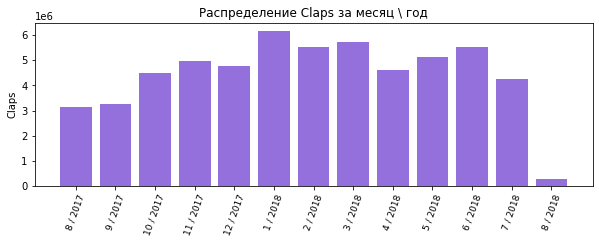

In [ ]:
# Посмотрим распредление статей по времени

years = [2017,2018]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
ym_counts = []
date = []
for year in years:
    for month in months:
        ym_counts.append(data[(data.Year==year)&(data.Month==month)].Claps.sum())
        date.append(str(month)+" / "+str(year))

# удаляем месяцы в которых не было статей
ym_counts = ym_counts[7:-4]     
date = date[7:-4]


plt.figure(figsize=(10,3))
plt.bar(date, ym_counts, color = "#9370DB")
plt.title("Распределение Claps за месяц \ год", fontsize=12)
plt.ylabel("Claps")
plt.xticks(rotation=70, fontsize=9)
plt.show()

# дата публикации статьи как-то не очень влияет на Claps

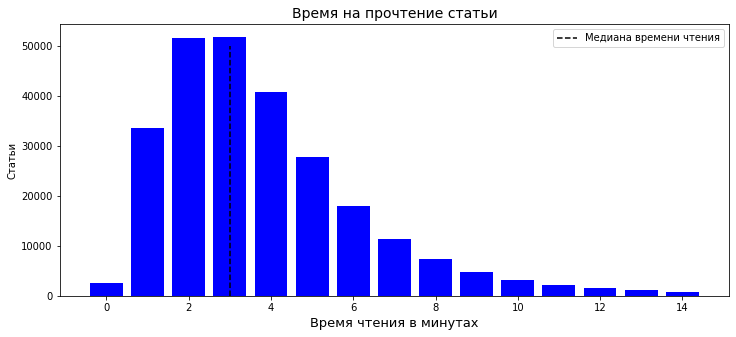

In [ ]:
avs=[]
medians=[]
total_cs = []
readts=[]
entries = []
for x in range(15):
    medians.append(data[data.Reading_Time==x].Claps.quantile(q=0.5))
    readts.append(x)
    entries.append(data[data.Reading_Time==x].shape[0])
    total_cs.append(data[data.Reading_Time==x].Claps.sum())

plt.figure(figsize=(12,5))
plt.bar(readts,entries, color="blue")
plt.vlines(data.Reading_Time.median(),0,50000,
           color="black",
           linestyle="dashed",
           label="Медиана времени чтения")
plt.title("Время на прочтение статьи", fontsize=14)
plt.ylabel("Статьи")
plt.xlabel("Время чтения в минутах", fontsize=13)
plt.legend()

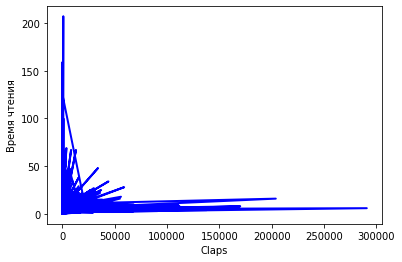

In [ ]:
def lineplot(x_data, y_data, x_label="", y_label="", title=""):
    _, ax = plt.subplots()

    ax.plot(x_data, y_data, lw = 2, color = 'blue', alpha = 1)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

lineplot(data.Claps, data.Reading_Time, "Claps", "Время чтения")
# можно сказать, что, чем меньше время чтения, тем больше Claps

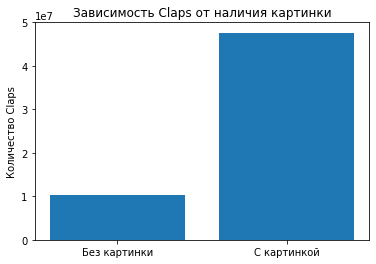

In [ ]:
objects = ('Без картинки' , 'С картинкой')
y_pos = np.arange(len(objects))
performance = [data[data.Image==0].Claps.sum(), data[data.Image==1].Claps.sum()]
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Количество Claps')
plt.title('Зависимость Claps от наличия картинки')

plt.show()

**2. Конструирование текстовых признаков **


In [ ]:
# посчитаем кол-во токенов в тайтле
data['len_tokens'] = data['Title'].apply(lambda x: len(x.split()))

In [ ]:
! pip install razdel

In [ ]:
def preproc_text(text):
    # токенизируем
    tokens = [_.text for _ in list(tokenize(text))]
    
    # приводим к нижнему регистру
    tokens = [w.lower() for w in tokens]
    
    # убираем пунктуацию
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # убираем числа и оставлем только кирилицу
    words = [word for word in stripped if word.isalpha()]
    
    # удаляем стоп-слова
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    text = ' '.join(words)
    
    return text

In [ ]:
# добавим пробелы в конец тайтлова чтобы соединить их с сабтайтлами
titles = []
for title in data['Title']:
  title = title + ' '
  titles.append(title)

# обновим тайтлы
data['Title'] = titles

# соедним 
data['text'] = data['Title'] + data['Subtitle']


In [ ]:
# препроцессинг для тайтлов и сабтайтлов
from tqdm.auto import tqdm
clean_texts = [] 
for t in tqdm(data['text']):
  clean_texts.append(preproc_text(t))

data['clean_text'] = clean_texts

In [ ]:
# посмотрим на распределение Clpas
data.sort_values('Claps', ascending = False).Claps[:1000].describe()

count      1000.000000
mean      15232.810000
std       18032.365042
min        6200.000000
25%        7800.000000
50%       10100.000000
75%       15600.000000
max      291000.000000
Name: Claps, dtype: float64

In [ ]:
# соберем слова из тайтлов, где больше всего Claps
hypewords = []
for text in tqdm(data.sort_values('Claps', ascending = False).Title[:1000]):
  for t in text.split():
    hypewords.append(preproc_text(t))

# возьмем 100 самый употребляемых слов из предыдущего списка
from collections import Counter
words = []
for i in Counter(hypewords).most_common(100):
  words.append(i[0])

In [ ]:
# посчитаем для каждой стати хайповые слова в тайтле 
hype_words_number = []
for title in tqdm(data.Title):
  n = 0
  for w in title.split():
    if preproc_text(w) in words:
      n+=1
  hype_words_number.append(n)

data['hype_words_number'] = hype_words_number

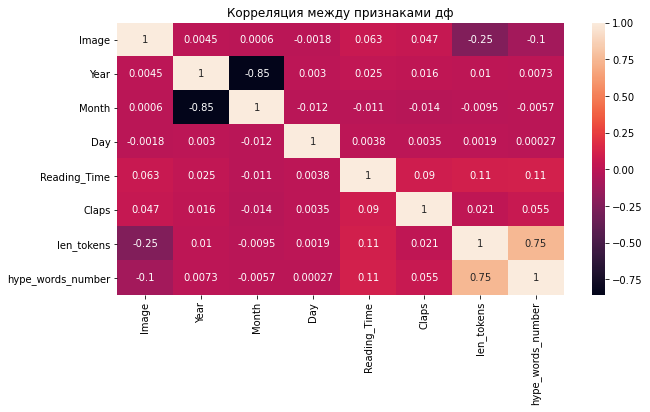

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    data=data.corr(), 
    annot=True,
    ax=ax
)

plt.title("Корреляция между признаками дф")
plt.show()

Из матрицы видим,что больше всего корреляция между временем чтении, наличием хайповых слов, с наличием картинки и совсем неменого с кол-вом токенов

In [ ]:
# разделим выборку на тест и трейн
from sklearn.model_selection import train_test_split
test, train = train_test_split(data, test_size = 0.8, random_state = 42)

In [ ]:
# создадим матрицу векторов
# используем для корпуса текстов тайтлы и сабтайтлы статей 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(lowercase=False)
full_tfidf = tfidf_vec.fit_transform(train['clean_text'].values.tolist() + test['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['clean_text'].values.tolist())

In [ ]:
# получим SVD компоненты для наших тфидф матриц

from sklearn.decomposition import TruncatedSVD
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train, train_svd], axis=1)
test_df = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
# удалим пустые значения (я не знаю почему они появляются из трейна и тестa)
for col_name in test_df.columns:
    num_nan_values = len(test_df[test_df[col_name].isna()])
    if num_nan_values > 0:
        test_df = test_df.dropna(subset=[col_name])

for col_name in train_df.columns:
    num_nan_values = len(train_df[train_df[col_name].isna()])
    if num_nan_values > 0:
        train_df = train_df.dropna(subset=[col_name])

**3. Отбор важных признаков, поиск гиперпараметров, минимизация переобучения **

In [ ]:
# целевая переменная
train_y = train_df["Claps"].values

from sklearn import preprocessing, model_selection, metrics

# переведем категориальные пременные в лейблы 
cat_vars = ["Author", "Publication"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

# удаляем ненужные колонки
cols_to_drop = ["Title", "Subtitle", "clean_text", "text"]
train_X = train_df.drop(cols_to_drop + ["Claps"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [ ]:
# создадим функцию для построения модели LightGBM.
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 100, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [ ]:
# Разделим данные для тренировки модели
dev_X = train_X.iloc[:-5000,:]
val_X = train_X.iloc[-5000:,:]
dev_y = train_y[:-5000]
val_y = train_y[-5000:]
print(dev_X.shape, val_X.shape, test_X.shape)

# Тренируем модель

pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

# Сохраним результаты в отдельную таблицу
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
rmse_df = pd.DataFrame()
rmse_df["Claps"] = pred_test

(156665, 12) (5000, 12) (10270, 13)
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 1063.82
[40]	valid_0's rmse: 1066.43
[60]	valid_0's rmse: 1068.79
[80]	valid_0's rmse: 1069.03
[100]	valid_0's rmse: 1070.35
Did not meet early stopping. Best iteration is:
[8]	valid_0's rmse: 1063.64


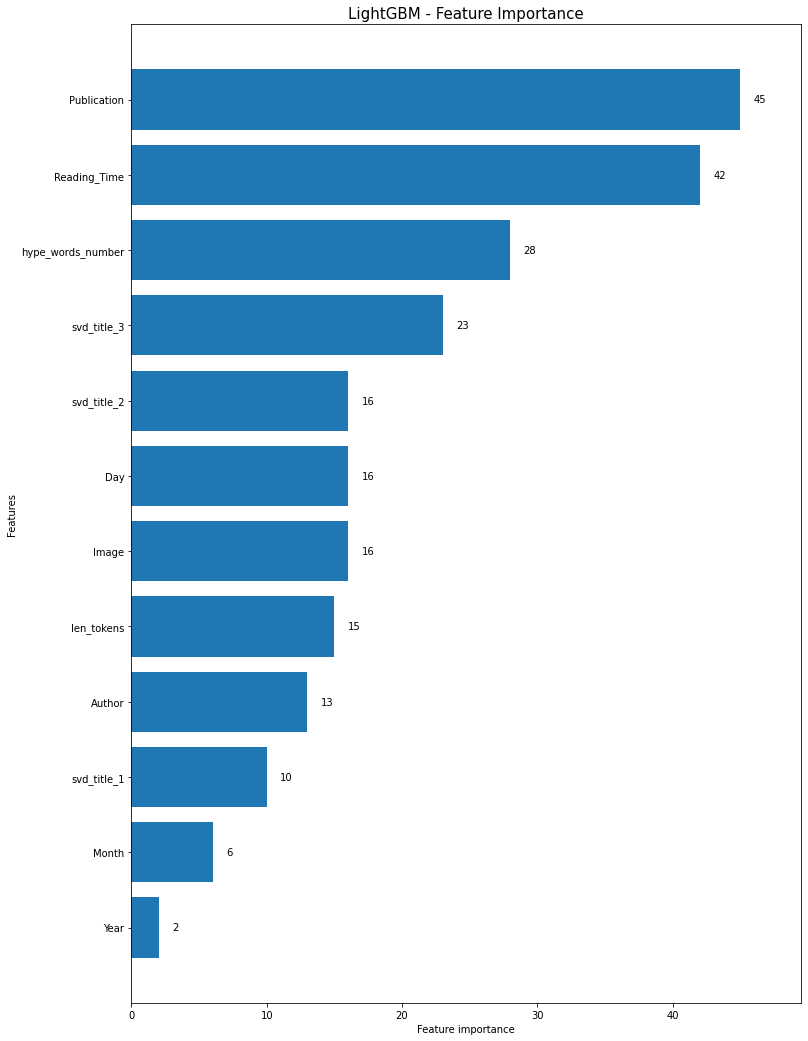

In [ ]:
# Посмотрим на важность признаков 
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

Вот так мы определили важные признаки: название статьи,  время чтения, публикацию, хайповые слова и наличие картинки

In [ ]:
X_train = train_df[['svd_title_3', 'hype_words_number', 'Publication', 'Image', 'Reading_Time' ]]
y_train = train_df['Claps']
X_test = test_df[['svd_title_3', 'hype_words_number', 'Publication', 'Image', 'Reading_Time' ]]
y_test = test_df['Claps']

**4. Адаптация аугментации данных с заменой слов **


In [ ]:
!wget -c http://vectors.nlpl.eu/repository/20/5.zip
!unzip 5.zip

In [ ]:
import gensim


model_eng = gensim.models.KeyedVectors.load_word2vec_format("model_en.bin", binary=True)
model_eng.init_sims(replace=True)

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def augment_word2vec_eng(sentence, model=model_eng):

    # tokens = list(tokenize(str(sentence)))
    words = nltk.word_tokenize(sentence)
    new_sent = []
    for word in words:
        lemma = lemmatizer.lemmatize(str(word))
        if lemma in model:
            w = model.most_similar(lemma)[0]
            new_sent.append(str(w[0]))
        else:
           new_sent.append(word)
    return ' '.join(new_sent)

augment_word2vec_eng('mother on the test set')

'grandmother with of testing CITATION'

In [ ]:
# датасет очень большой, так что просто покажу как в теории можно делать
# аугументацию данных на игрушечном примере

aug_title = []
for t in data.Title[:50]:
  new_title = augment_word2vec_eng(t)
  aug_title.append(new_title)

In [ ]:
for i in aug_title[:10]:
  print(i)

The Product Generated through ai LED mindfulness
Paralamas Melhores Golf la JulhoCmeras vintage , Gmail Stained , Trek Trek hotel
The Tense and ai : Redefining How We Imagine
Serverless Prefabricated PaaS Accelerates Entrepreneurship Dynamic
Chatbot2022630
nx-01 chat Daily roundup # 2
The Sub/Tweet : ai hectare arrived
XiaomiAmazon Bunnymen $ 44
iTranslate Hollister
API.AI a Lines messaging api ( build-operate-transfer ) # # 2


**5. Сравнение качества моделей, выбор наилучшей **

In [ ]:
# Масштабируем признаки для модели
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# фиттим
scaler.fit(X_train)
# трасформируем данные
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

clf = KNeighborsClassifier().fit(X_train, y_train)
predicted = clf.predict(X_test)

# оцениваем модель
mae = np.mean(abs(predicted - y_test))

print('KNeighborsClassifier Performance on the test set: MAE = %0.4f' % mae)

KNeighborsClassifier Performance on the test set: MAE = 159.4960


In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

# оцениваем модель
mae = np.mean(abs(predicted - y_test))

print('MultinomialNB Performance on the test set: MAE = %0.4f' % mae)

MultinomialNB Performance on the test set: MAE = 159.9733


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
# оцениваем модель
mae = np.mean(abs(predicted - y_test))

print('Ridge Performance on the test set: MAE = %0.4f' % mae)

Ridge Performance on the test set: MAE = 226.1592


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
predictions = clf.predict(X_test)
mae = np.mean(abs(predictions - y_test))

print('DecisionTreeClassifier Performance on the test set: MAE = %0.4f' % mae)

DecisionTreeClassifier Performance on the test set: MAE = 241.1375


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor().fit(X_train, y_train)
predicted = clf.predict(X_test)
# оцениваем модель
mae = np.mean(abs(predicted - y_test))
print('Gradient Boosted Performance on the test set: MAE = %0.4f' % mae)

Gradient Boosted Performance on the test set: MAE = 216.8038


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# количество соседей
n_neighbors = [2, 3, 4, 5]

# веса
weights = ['uniform', 'distance']

# метрика расстояния
metric = ['euclidean', 'manhattan']

# определяем гиперпараметры
hyperparameter_grid = {'n_neighbors': n_neighbors,
                       'weights': weights,
                       'metric': metric}


grid = GridSearchCV(KNeighborsClassifier(), 
                    hyperparameter_grid, 
                    verbose = 1, 
                    cv=3,
                    n_jobs = -1)

grid_result = grid.fit(X_train, y_train) 

grid_result.best_estimator_
grid_result.best_score_
grid_result.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.0min finished


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

clf = KNeighborsClassifier().fit(X_train, y_train)
predicted = clf.predict(X_test)

# оцениваем модель
mae = np.mean(abs(predicted - y_test))

print('KNeighborsClassifier Performance on the test set: MAE = %0.4f' % mae)


default_model = KNeighborsClassifier().fit(X_train, y_train)
default_pred = default_model.predict(X_test)

final_model = KNeighborsClassifier(n_neighbors=19, 
                                   weights='uniform', 
                                   metric='manhattan')
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)


mae_d = np.mean(abs(default_pred - y_test))
mae_f = np.mean(abs(final_pred - y_test))
print('Default model performance on the test set: MAE = %0.4f' % mae_d)
print('Final model performance on the test set: MAE = %0.4f' % mae_f)

KNeighborsClassifier Performance on the test set: MAE = 159.4960
Default model performance on the test set: MAE = 159.4960
Final model performance on the test set: MAE = 159.6410



### **Блок 3: Paraphrase Detection ** 

длину текста, среднее количество стоп-слов в тексте, среднюю длину предложения, количество смайликов... все, что, на ваш взгляд, как-то может помочь решить вашу задачу, то есть признаки, которые, на ваш взгляд, кодируют какую-то ценную информацию

In [ ]:
import pandas as pd
para = pd.read_csv("paraphrases.tsv", sep="\t")
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1


**1. Эксплоративный анализ данных (1 балл) и Конструирование текстовых признаков (2 балла)**

In [ ]:
# Смотрим, есть ли NaN значения, и удаляем их

for col_name in para.columns:
    num_nan_values = len(para[para[col_name].isna()])
    print("Number of NaN values in %s column is %d" % (col_name, num_nan_values))
    if num_nan_values > 0:
        para = para.dropna(subset=[col_name])

print()
print("Total number of rows is %d" % para.shape[0])

# Поправим индексы
para = para.reset_index(drop=True)

Number of NaN values in text_1 column is 0
Number of NaN values in text_2 column is 0
Number of NaN values in class column is 0

Total number of rows is 8540


In [ ]:
# Пропорция уникальных текстов
for col in ['text_1', 'text_2']:
  print(len(para[col].unique()) / para.shape[0])
  # Удаление дубликатов
  para = para.drop_duplicates(subset=[col])
  print(len(para[col].unique()) / para.shape[0])

# после этого еще раз запустим ячеку с удалением Nan

0.4436768149882904
1.0
0.8722618105040908
1.0


In [ ]:
# посмотрим распределение классов
para['class'].value_counts()

-1    1787
 1    1518
Name: class, dtype: int64

In [ ]:
# добавим параметр длины текстов
para['len_text_1'] = para['text_1'].apply(len)
para['len_text_2'] = para['text_2'].apply(len)
para['len_text']= para[['len_text_1', 'len_text_2']].values.tolist()


# и длины токенов
para['text_len_tokens_1'] = para['text_1'].apply(lambda x: len(x.split()))
para['text_len_tokens_2'] = para['text_2'].apply(lambda x: len(x.split()))
para['text_len_tokens']= para[['text_len_tokens_1', 'text_len_tokens_2']].values.tolist()

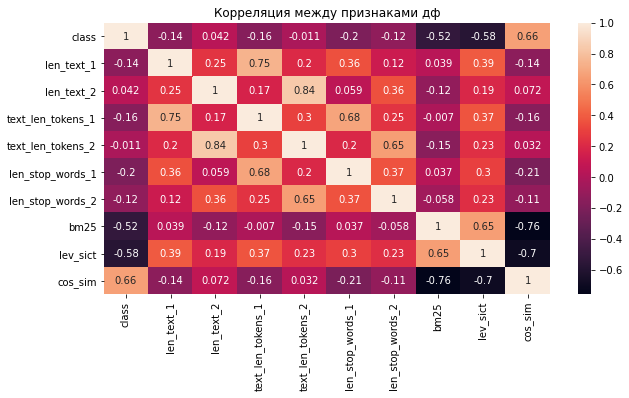

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    data=para.corr(), 
    annot=True,
    ax=ax
)

plt.title("Корреляция между признаками дф")
plt.show()

The features include the following groups: string-based features, informationretrieval features, part-of speech features, and thesaurus-based features.
String-based features include features for two and three symbol N-grams, and
for word one, two and three N-grams. For each type of N-grams, the string feature
group comprises the following three features:

In [ ]:
# посчиаем кол-во стоп-слов в тексте

def cout_stopwords(text):
  # разделяем текст на токены и приводим к нижнему регистру
  tokens = [_.text for _ in list(tokenize(text))]
  tokens = [w.lower() for w in tokens]

  # считаем стоп-слова
  stop_words = set(stopwords.words('russian'))
  num_stop = 0
  for w in tokens:
    if w  in stop_words:
      num_stop += 1
  return num_stop

# посчитаем сто слова для первого и второго текста 
def stop_w(col, new_col):
  num_stop_words = []
  for text in para[col]:
    num_stop_words.append(cout_stopwords(text))
  para[new_col] = num_stop_words

stop_w('text_1', 'len_stop_words_1')
stop_w('text_2', 'len_stop_words_2')

# соединим фичи в список
para['len_stop_words']= para[['len_stop_words_1', 'len_stop_words_2']].values.tolist()


In [ ]:
!pip install rank_bm25

In [ ]:
# посчитаем близость между текстами bm25
from rank_bm25 import BM25Okapi

bm_25_score = []
for i, y in zip(para.text_1, para.text_2):
  corpus = [i, y]
  tokenized_corpus = [doc.split(" ") for doc in corpus]
  bm25 = BM25Okapi(tokenized_corpus)
  query = corpus[1]
  tokenized_query = query.split(" ")
  doc_scores = bm25.get_scores(tokenized_query)
  bm_25_score.append(doc_scores[0])

para['bm25'] = bm_25_score

In [ ]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144794 sha256=3f5c5b197d822f036dded62de3fed2646e20d6a0f9fdcc1f2c26355f041a590f
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [ ]:
import Levenshtein
lev_dist = []
for i, y in zip(para.text_1, para.text_2):
  lev_dist.append(Levenshtein.distance(i, y))
  
para['lev_sict'] = lev_dist

In [ ]:
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

def clean_text(text):
  text = ''.join([word for word in text if word not in string.punctuation])
  text = text.lower()
  stop_words = set(stopwords.words('russian'))
  words = [w for w in text.split() if not w in stop_words]
  return ' '.join(words)

cos_sim = []
for t1, t2 in zip(para.text_1, para.text_2):
  cleaned = list(map(clean_text, [t1, t2]))
  vectorizer = CountVectorizer().fit_transform(cleaned)
  vectors = vectorizer.toarray()
  csim = cosine_similarity(vectors)
  cos_sim.append(csim[0][1])

para['cos_sim'] = cos_sim

**3. Аугментация данных (1 балл)**

In [ ]:
import tqdm

In [ ]:
aug = para[:1000]
aug_text_1 = []
for t in aug.text_1:
  new = augment_word2vec_pos(t, ['NOUN', 'ADVB', 'ADJF', 'ADJS'])
  aug_text_1.append(new)

aug['text_1'] = aug_text_1

In [ ]:
aug_text_2 = []
for t in aug.text_2:
  new = augment_word2vec_pos(t, ['NOUN', 'ADVB', 'ADJF', 'ADJS'])
  aug_text_2.append(new)

aug['text_2'] = aug_text_2

In [ ]:
aug_cos_sim = []
for t1, t2 in zip(aug.text_1, aug.text_2):
  cleaned = list(map(clean_text, [t1, t2]))
  vectorizer = CountVectorizer().fit_transform(cleaned)
  vectors = vectorizer.toarray()
  csim = cosine_similarity(vectors)
  aug_cos_sim.append(csim[0][1])

aug['cos_sim'] = aug_cos_sim

In [ ]:
aug_lev_dist = []
for t1, t2 in zip(aug.text_1, aug.text_2):
  aug_lev_dist.append(Levenshtein.distance(t1, t2))
  
aug['lev_sict'] = aug_lev_dist

In [ ]:
aug_bm_25_score = []
for i, y in zip(aug.text_1, aug.text_2):
  corpus = [i, y]
  tokenized_corpus = [doc.split(" ") for doc in corpus]
  bm25 = BM25Okapi(tokenized_corpus)
  query = corpus[1]
  tokenized_query = query.split(" ")
  doc_scores = bm25.get_scores(tokenized_query)
  aug_bm_25_score.append(doc_scores[0])

aug['bm25'] = aug_bm_25_score

In [ ]:
aug_para = pd.concat([para, aug], ignore_index=True)

**4. Сравнение качества моделей, выбор наилучшей (1 балл)**

In [ ]:
# соединим наши данные с аугуменированными
X = aug_para[['bm25', 'lev_sict', 'cos_sim']] 
y = aug_para['class'] 

In [ ]:
from sklearn import preprocessing
# standardize the data attributes
standardized_X = preprocessing.scale(X)

In [ ]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X, y)
# посмотрим относительную важность каждого нашего атрибута
print(model.feature_importances_)
# они примерно одинаковые

[0.33683783 0.30012391 0.36303827]


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# создадим RFE model и выберем 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(X, y)
# суммируем выбор атрибутов
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True]
[1 1 1]


In [ ]:
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y)
print(model)
# сделаем предсказание
expected = y
predicted = model.predict(X)
# суммируем фит модели
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

          -1       0.80      0.87      0.83      2374
           1       0.82      0.73      0.77      1931

    accuracy                           0.81      4305
   macro avg       0.81      0.80      0.80      4305
weighted avg       0.81      0.81      0.81      4305

[[2056  318]
 [ 515 1416]]


In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
# попробуем другую модель
model = KNeighborsClassifier()
model.fit(X, y)
print(model)
# сделаем предсказание
expected = y
predicted = model.predict(X)
# суммируем фит модели
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

          -1       0.86      0.89      0.88      2374
           1       0.86      0.82      0.84      1931

    accuracy                           0.86      4305
   macro avg       0.86      0.86      0.86      4305
weighted avg       0.86      0.86      0.86      4305

[[2123  251]
 [ 342 1589]]


In [ ]:
# Потестим еще несколько моделей

In [ ]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X, y)
print(model)
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
# кажется что модель переобучилась

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      2374
           1       1.00      0.98      0.99      1931

    accuracy                           0.99      4305
   macro avg       0.99      0.99      0.99      4305
weighted avg       0.99      0.99      0.99      4305

[[2372    2]
 [  34 1897]]


In [ ]:
from sklearn import metrics
from sklearn.svm import SVC
model = SVC()
model.fit(X, y)
print(model)
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

          -1       0.77      0.84      0.80      2374
           1       0.78      0.69      0.73      1931

    accuracy                           0.77      4305
   macro avg       0.77      0.76      0.77      4305
weighted avg       0.77      0.77      0.77      4305

[[1997  377]
 [ 607 1324]]


**2. Поиск гиперпараметров, минимизация переобучения (2 балла)**

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# подготовим список значений альфа для тестирования лучшего 
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# зафитим модель Ridge
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X, y)
print(grid)
# посмотрим на результаты grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.4490381160813565
1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# наши предсказания будем делать на этой модели с параметрами которые мы подобрали в грид серч
reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
# оцениваем модель (тут аккураси нельзя, потому что другие предсказания)
mae = np.mean(abs(predicted - y_test))
mean_squared_error(y_test, predicted)
print('Ridge Performance on the test set: MAE = %0.4f' % mean_squared_error)

0.5833757004999965

In [ ]:
# подготовим список значений альфа для тестирования лучшего 
# количество соседей
n_neighbors = [2, 3, 4, 5, 7, 8]

# веса
weights = ['uniform', 'distance']

# метрика расстояния
metric = ['euclidean', 'manhattan']

# определяем гиперпараметры
hyperparameter_grid = {'n_neighbors': n_neighbors,
                       'weights': weights,
                       'metric': metric}


grid = GridSearchCV(KNeighborsClassifier(), 
                    hyperparameter_grid, 
                    verbose = 1, 
                    cv=3,
                    n_jobs = -1)

grid.fit(X, y)
print(grid)
# посмотрим на результаты grid search
print(grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [2, 3, 4, 5, 7, 8],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)
0.8666666666666667


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.9s finished


In [ ]:
# грид кажеся выбрал такие же параметры, которые мы использовали раньше
# продублирую код
model = KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform')
model.fit(X, y)
print(model)
# сделаем предсказание
expected = y
predicted = model.predict(X)
# суммируем фит модели
print(metrics.classification_report(expected, predicted))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

          -1       0.86      0.89      0.88      2374
           1       0.86      0.82      0.84      1931

    accuracy                           0.86      4305
   macro avg       0.86      0.86      0.86      4305
weighted avg       0.86      0.86      0.86      4305

[[2123  251]
 [ 342 1589]]


**6. Анализ ошибок (1 балл)**

1. Наверное можно было лучше поподбирать параметры моделей, попробовать еще другие штуки и прогнать все через грид серч. 
2. Может стоило остановится на каком-то одном параметре близости текстов чтобы не перегружать модель
3. Веротяно стоило добавить еще тектовых признаков типо Н-грамм и\или может каких-то штук связанными с пос тегами
